## Binary logistic regression

Written by Jess Breda June 2023

In [90]:
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt

Steps
-----
1. generate the dataset
2. Define cost & gradient fx
3. Initialize weights & run optimization
4. Visualize

In [91]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# -- PLOT FUNCTIONS -- #
def generate_sigmoids(true_W, optimized_W):
    # create a matrix X with bias column to pass
    # to the sigmoid function
    x_range = np.linspace(-10, 10, 100)
    n_features = len(true_W) - 1
    X_with_bias = np.tile(x_range, (n_features, 1)).T
    X_with_bias = np.c_[np.ones_like(x_range), X_with_bias]  # add bias column

    true_logits = X_with_bias @ true_W
    true_probabilities = sigmoid(true_logits)

    optimized_logits = X_with_bias @ optimized_W
    optimized_probabilities = sigmoid(optimized_logits)

    return x_range, true_probabilities, optimized_probabilities


def plot_sigmoids(x_range, true_probabilities, optimized_probabilities):
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(x_range, true_probabilities, label="true", color="gray")
    ax.plot(
        x_range,
        optimized_probabilities,
        label="optimized",
        color="gray",
        linestyle="--",
    )
    ax.legend()
    ax.set(title="Sigmoid Functions", xlabel="Logits", ylabel="Probability")


def plot_weights(true_W, optimized_W):
    fig, ax = plt.subplots(figsize=(6, 4))

    feature_and_bias_labels = np.arange(len(true_W))

    ax.plot(feature_and_bias_labels, true_W, label="true", color="gray", marker="o")
    ax.plot(
        feature_and_bias_labels,
        optimized_W,
        label="optimized",
        color="gray",
        marker="o",
        linestyle="dashed",
    )

    # Set the x-axis tick labels
    _ = ax.set_xticks(feature_and_bias_labels)
    ax.set(xlabel="Feature", ylabel="Weight", title="Recovered Weights")
    ax.legend()

### 1. Generate Data

In [116]:
N = 100000  # Number of samples
D = 2  # Number of features

# Generate random feature values
# X = np.random.randn(N, D)  ## convert to Normal
X = np.random.normal(size=(N, D))

# Generate random true weights (including the bias coefficient)
# true_W = np.random.rand(D + 1)
true_W = np.random.normal(loc=0, scale=1, size=(D + 1))

# Add bias column to the dataset
X_with_bias = np.c_[np.ones(N), X]

# Generate target labels using logistic function
logits = X_with_bias @ true_W
probabilities = sigmoid(logits)
y = np.random.binomial(1, probabilities)

### 2. Define cost & gradient functions

These are passed into scipys' `minimize` function. Note `X` includes a first bias column of 1s.

$$ \text{{logits}} = X \cdot W $$

1. Logistic Regression Cost Function:

$$ \text{{nll}} = \frac{1}{n} \sum_{i=1} ^{n}(y \cdot \log(\text{logits}) - \log(1 + \exp(\text{logits})))$$

$$ \text{{nll}} = \frac{1}{n} \sum_{i=1} ^{n}(y \cdot \log(\text{a}) - \log(1 + \exp(\text{a})))$$

2. Logistic Regression Gradient Function:

$$p(y) = 1 - \frac{1}{1 + \exp(\text{logits})}$$

$$\nabla \text{nll}_W = \frac{{X^T \cdot (\text{{p(y)}} - y)}}{N}$$


3. Logistic Regression Hessian Function:

$$ \text{Hess} = \frac{1}{n} \sum_{i=1} ^{n} (p(y_i) (1 - p(y_i)) x_i x_i^T )

In [117]:
def logistic_regression_cost(w, X, y, sigma=None):
    """
    Compute the negative log-likelihood for binary
    logistic regression with L2 regularization (or MAP).

    params
    ------
    w : weights
    X : data (with bias column)
    Y : target labels, not used but keeping scipy minimize happy
    sigma : float (defualt: None)
        Standard deviation of Gaussian prior, if None
        no regularization is applied.

    returns
    -------
    nll : (regularized) negative log-likelihood
    """
    logits = X @ w

    if sigma:
        penalty = 1 / (2 * sigma**2) * np.sum(w**2)
    else:
        penalty = 0

    nll = -np.mean(y * logits - np.log(1 + np.exp(logits))) + penalty
    return nll


def logistic_regression_gradient(w, X, y, sigma=None):
    """
    Gradient of the cost function for logistic regression using negative log-likelihood

    w: weights
    X : data (with bias column)
    y : target labels (0,1)
    """
    logits = X @ w
    p = 1 - 1 / (1 + np.exp(logits))

    if sigma:
        penalty_gradient = w / sigma**2
        penalty_gradient[0] = 0  # No penalty for bias
    else:
        penalty_gradient = 0

    gradient = (np.dot(X.T, (p - y)) / len(y)) + penalty_gradient
    return gradient


def compute_logistic_regression_hessian(W, X, y):
    """
    Hessian matrix of the cost function for logistic regression using negative log-likelihood.

    W : weights
    X : data (with bias column)
    y : target labels (0,1)

    NOTE: needs to be checked
    """
    logits = X @ W
    probabilities = 1 - 1 / (1 + np.exp(logits))
    # Outer product for each data point's feature vector and summing them up
    hessian = sum(
        [(prob * (1 - prob) * np.outer(xi, xi)) for xi, prob in zip(X, probabilities)]
    )
    return hessian / len(y)  # Average over all data points

### 3. Initialize Weights & Optimize

L-BFGS-B versus L-BFGS versus BFGS.

**BFGS:** is a quasi-newton method used for optimization that avoids the costly computation of the Hessian. It approximates the inverse Hessian via gradient updates.

**L-BFGS**: is the limited-memory version of BFGS, doesn't store the full Hessian matrix (or inverse), but instead a subset of vectors that represent this matrix

**L-BFGS-B**: is limited memory version + "bounds". You can implemented bound constraints on the variables being optimized to help minimized the search space. If this is implemented without the `bounds` argument, it is the same as L-BFGS.

In [124]:
initial_W = np.zeros(D + 1)  # Initial guess for weights

# optimize using L-BFGS-B algorithm
result = minimize(
    logistic_regression_cost,
    initial_W,
    args=(X_with_bias, y),
    method="BFGS",
    jac=logistic_regression_gradient,
    options={"disp": True},
)
optimized_W = result.x

Optimization terminated successfully.
         Current function value: 0.510978
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14


In [125]:
# summarize the result
print("Status : %s" % result["message"])
print("Total Evaluations: %d" % result["nfev"])

print("True weights:", true_W)
print("Optimized weights:", optimized_W)

Status : Optimization terminated successfully.
Total Evaluations: 14
True weights: [ 1.04159195  1.08438686 -0.4638284 ]
Optimized weights: [ 1.03964335  1.08709876 -0.47097824]


In [126]:
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.5109775715031334
        x: [ 1.040e+00  1.087e+00 -4.710e-01]
      nit: 13
      jac: [ 2.960e-06 -3.449e-06  4.223e-06]
 hess_inv: [[ 6.507e+00  2.822e+00 -1.446e+00]
            [ 2.822e+00  7.134e+00  2.239e-01]
            [-1.446e+00  2.239e-01  4.962e+00]]
     nfev: 14
     njev: 14

### 5. Visualize the results

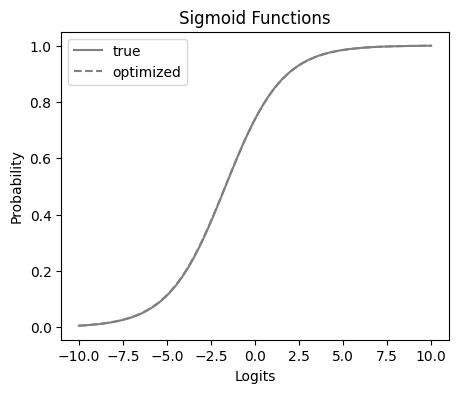

In [120]:
x_range, true_sig, optimized_sig = generate_sigmoids(true_W, optimized_W)
plot_sigmoids(x_range, true_sig, optimized_sig)

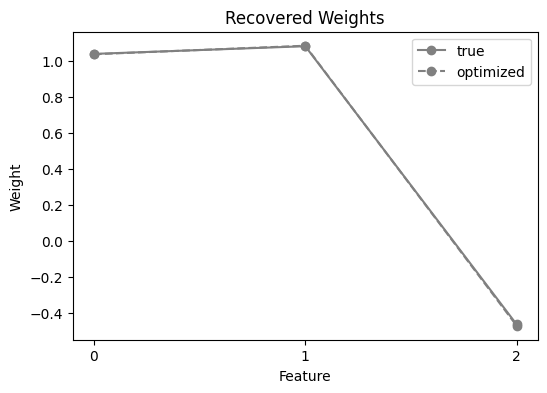

In [121]:
plot_weights(true_W, optimized_W)

## Validation of MAP $\sigma$

In [127]:
N = 2500  # Number of samples
D = 50  # Number of features

# Generate random feature values
X = np.random.normal(size=(N, D))
X_with_bias = np.c_[np.ones(N), X]  # bias column


# Generate random true weights given true sigma (including the bias coefficient)
true_sigma = 2
true_w = np.random.normal(loc=0, scale=true_sigma, size=D + 1)


# Generate target labels using logistic function
logits = X_with_bias @ true_w
probabilities = sigmoid(logits)
y = np.random.binomial(1, probabilities)

print(f"Generated {N} samples with {D} features")
print(f"w is {true_W.shape} \nX is {X_with_bias.shape} \ny is {y.shape}")

print(
    f"w has mean {np.mean(true_w):.3f} and std {np.std(true_w):.3f} with set sigma of {true_sigma}"
)

Generated 2500 samples with 50 features
w is (3,) 
X is (2500, 51) 
y is (2500,)
w has mean 0.069 and std 2.119 with set sigma of 2


In [89]:
logits.shape

(2500,)

In [128]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_with_bias, y, test_size=0.99, random_state=42
)

print(f"Generated train-test split of sample size {len(X_train)} and {len(X_test)}")

Generated train-test split of sample size 25 and 2475


### 2. Compute test nll over sigmas


In [129]:
y.shape

(2500,)

In [130]:
# initalize
initial_w_flat = np.zeros(D + 1)
sigmas = np.arange(0.1, 6, 0.1)
test_nlls = []
optimized_w_sigma = []
mses = []

# iterate over sigmas, find optimal W, and compute test NLL
for sigma in sigmas:
    result = minimize(
        fun=logistic_regression_cost,
        x0=initial_w_flat,
        args=(X_train, y_train, sigma),
        method="BFGS",
        jac=logistic_regression_gradient,
        options={"disp": True, "maxiter": 10000},
    )

    optimized_w = result.x

    # store out
    optimized_w_sigma.append(np.std(optimized_w))
    test_nlls.append(logistic_regression_cost(optimized_w, X_test, y_test, sigma=None))
    mses.append(np.mean((optimized_w - true_w) ** 2))

         Current function value: 0.690259
         Iterations: 1
         Function evaluations: 46
         Gradient evaluations: 35
         Current function value: 0.681824
         Iterations: 1
         Function evaluations: 53
         Gradient evaluations: 42
         Current function value: 0.668494
         Iterations: 1
         Function evaluations: 56
         Gradient evaluations: 45
         Current function value: 0.651212
         Iterations: 1
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.631054
         Iterations: 1
         Function evaluations: 45
         Gradient evaluations: 34
         Current function value: 0.609073
         Iterations: 1
         Function evaluations: 48
         Gradient evaluations: 37
         Current function value: 0.586008
         Iterations: 2
         Function evaluations: 76
         Gradient evaluations: 64
         Current function value: 0.562619
         Iterations: 2
    

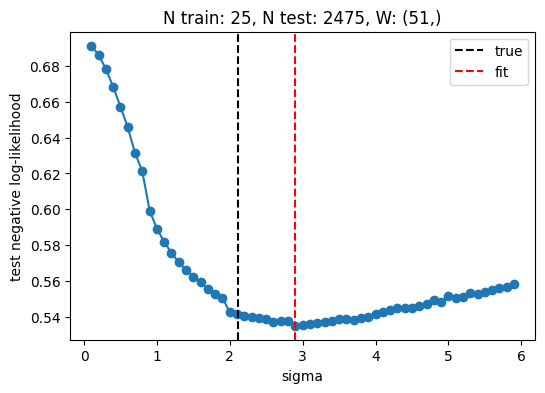

In [131]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sigmas, test_nlls, marker="o")
ax.axvline(x=np.std(true_w), color="k", linestyle="--", label="true")
ax.axvline(x=sigmas[np.argmin(test_nlls)], color="red", linestyle="--", label="fit")

ax.set(
    xlabel="sigma",
    ylabel="test negative log-likelihood",
    title=f"N train: {len(X_train)}, N test: {len(X_test)}, W: {true_w.shape}",
)
ax.legend()

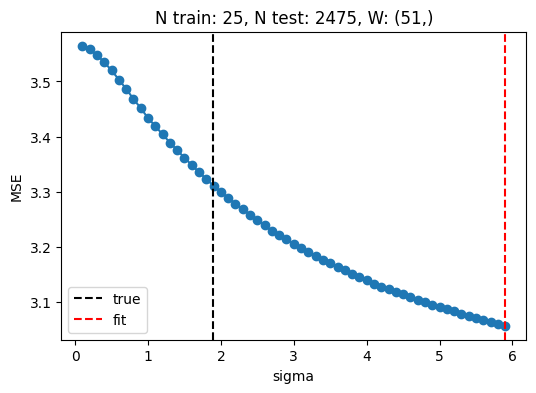

In [79]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sigmas, mses, marker="o")
ax.axvline(x=np.std(true_w), color="k", linestyle="--", label="true")
ax.axvline(x=sigmas[np.argmin(mses)], color="red", linestyle="--", label="fit")

ax.set(
    xlabel="sigma",
    ylabel="MSE",
    title=f"N train: {len(X_train)}, N test: {len(X_test)}, W: {true_w.shape}",
)
ax.legend()